In [36]:
from pathlib import Path

import torch
from tqdm import  tqdm
import numpy as np
import matplotlib.pyplot as plt

import project_path
import nn.utils as utils
import nn.model.net as net
import nn.model.data as data
import nn.model.loss as loss

## Constants

In [37]:
NUM_CLASSES = 5
CLASSES = ['Gluon', 'Lght quarks', 'W boson', 'Z boson', 'Top quark']
MODEL_DIR = Path("../experiments/constituent_perceiver_1/best.script.pth")

## Data

In [38]:
# (1) creating dataset
datasets = data.get_dataset(splits=['train-val', 'test'])
dataset = datasets['train-val']

# (2) train-validation split
dataset_size = len(dataset)
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_size - 1000, 1000])

# (3) train-validation dataloaders
train_loader = data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=data.get_collate_fn())
val_loader = data.DataLoader(val_set, batch_size=32, collate_fn=data.get_collate_fn())

## Model

In [27]:
model = torch.jit.load(MODEL_DIR, map_location='cpu')
print(f'Number of parameters: {utils.count_parameters(model)}')
model.eval()

Number of parameters: 8533


RecursiveScriptModule(
  original_name=ConstituentNetPerceiver
  (perceivers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Perceiver
      (cross_transformer): RecursiveScriptModule(
        original_name=CrossTransformer
        (self_attention): RecursiveScriptModule(
          original_name=SelfAttention
          (norm): RecursiveScriptModule(original_name=LayerNorm)
          (qkv): RecursiveScriptModule(original_name=Linear)
          (out): RecursiveScriptModule(original_name=Linear)
        )
        (cross_attention): RecursiveScriptModule(
          original_name=Attention
          (norm): RecursiveScriptModule(original_name=LayerNorm)
          (queries): RecursiveScriptModule(original_name=Linear)
          (keys): RecursiveScriptModule(original_name=Linear)
          (values): RecursiveScriptModule(original_name=Linear)
          (out): RecursiveScriptModule(original_name=Linear)
        )
        (linear): Recur

## Evaluation

In [13]:
# Statistics summary
summ = []
outs_list = []
targs_list = []
atten_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs, energies = model(input_seqs)                 # torch.tensor (n, num_classes)
        attentions = torch.softmax(energies / (128 ** (1 / 2)), dim=-1)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())
        atten_list.append(attentions.detach().numpy())

        # Update tqdm
        t.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  2.91batch/s]


## Visualization

In [39]:
# Get single batch
batch = next(iter(val_loader))

# Unpack batch, move to device
input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
input_1ds = batch['input_1ds']    # torch.tensor (n, 16)
input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
targets = batch['targets']        # torch.tensor (n, )

# Model outputs
model = net.ConstituentNetPerceiver()
outputs, energies = model(input_seqs)       # torch.tensor (n, num_classes)
# attentions = torch.softmax(energies / (128 ** (1 / 2)), dim=-1)

In [40]:
print(input_1ds.shape)

torch.Size([32, 53])


In [25]:
energies.shape

torch.Size([32, 1, 4, 100])

In [14]:
targets[0]

tensor(0)

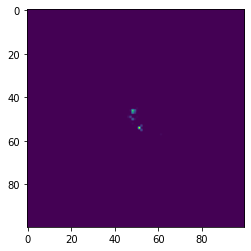

In [54]:
jet_images = batch['jetImages']
plt.imshow(jet_images[2])
plt.show()

(4, 8, 4, 100)


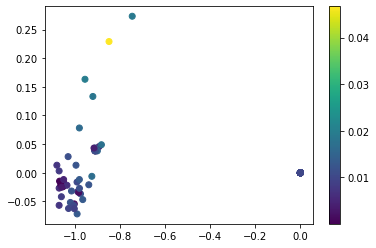

In [61]:
# attentions = attentions.detach().numpy()

print(attentions.shape)

x = input_seqs[2][:, 7]
y = input_seqs[2][:,11]
t = attentions[2][3][3,:]

plt.scatter(x, y, c=t, cmap='viridis')
plt.colorbar()
plt.show()
plt.show()

(array([4.35046e+05, 5.18975e+05, 5.28010e+04, 1.08040e+04, 3.33200e+03,
        1.59400e+03, 9.11000e+02, 4.11000e+02, 1.18000e+02, 8.00000e+00]),
 array([0.00327229, 0.02713426, 0.05099624, 0.07485821, 0.09872019,
        0.12258217, 0.14644414, 0.17030612, 0.19416809, 0.21803007,
        0.24189204], dtype=float32),
 <BarContainer object of 10 artists>)

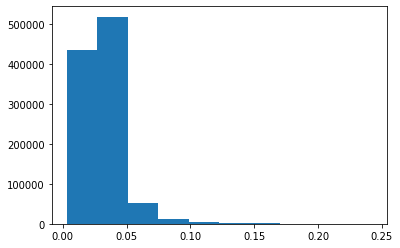

In [16]:
plt.hist(attentions.reshape(-1))

In [14]:
# Stack a list
attentions = np.vstack(atten_list)

In [17]:
atten_list[0].shape

(32, 1, 32, 32)

In [35]:
model.perceivers.cro

AttributeError: 'RecursiveScriptModule' object has no attribute 'cro'